# Visualization 

## Overview

In this session, we will use [fresnel](https://fresnel.readthedocs.io) to visualize snapshots. We will use a simple example of an atomistic molecule to begin with. This is not a complete fresnel tutorial, but it will give you a starting point. We also highly recommend to use other options ([Ovito](https://www.ovito.org/),[vmd](https://www.ks.uiuc.edu/Research/vmd/),..) for full simulation workflows. 

### Questions

- How do I define a configuration?
- How do we render simple snapshots and movies?

### Objectives

- Define a simple configuration of an atomistic and coarse-grained molecule.
- Learn how to render snapshots and change their properties (color, materials, light, camera angle)
- Learn how to make simple Gifs from MD trajectories.
  
## Boilerplate code

In this Notebook and all following notebooks, the first cell imports neccessary python modules and sets up some functions needed in the notebook. Usually, you do not need to modify this. 

In [4]:
import fresnel
import hoomd
import gsd,gsd.hoomd
import numpy 

Let's define a simple molecule by the positions of the atoms and their bonds. Here, we are defining the positions and bonds manually, whereas for larger simulations this is usually generated via simple algorithms/code or by external programs. Commonly, this information will be stored in either [gsd](https://gsd.readthedocs.io) files, the format hoomd-blue uses for managing trajectories, or in txt, json files.

In [ ]:
atomistic_positions = numpy.array([
    [3.1709,    0.2369,   -0.0001],
    [ 1.8649,   -0.5413,   -0.0114],
    [ 0.6558,    0.3935,    0.0001],
    [-0.6558,   -0.3932,    0.0227],
    [-1.8650,    0.5414,    0.0001],
    [-3.1709,   -0.2372,   -0.0115],
    [0.6840,    1.0388,   -0.8865],
    [0.7045,    1.0489,    0.8783],
    [-0.6930,   -1.0225,    0.9203],
    [-0.6952,   -1.0642,   -0.8441],
    [1.8337,   -1.2015,    0.8633],
    [1.8334,   -1.1803,   -0.9015],
    [-1.8442,    1.1983,    0.8775],
    [-1.8234,    1.1837,   -0.8874],
    [3.2485,    0.8856,   -0.8784],
    [4.0222,   -0.4510,   -0.0096],
    [3.2483,    0.8607,    0.8961],
    [-3.2373,   -0.8791,   -0.8958],
    [-3.2592,   -0.8681,    0.8788],
    [-4.0221,    0.4505,   -0.0263]
])

atomistic_bonds = numpy.array([
    [0,1],
    [1,2],
    [2,3],
    [3,4],
    [4,5],
    [0,14],
    [0,15],
    [0,16],
    [1,10],
    [1,11],
    [2,6],
    [2,7],
    [3,8],
    [3,9],
    [4,12],
    [4,13],
    [5,17],
    [5,18],
    [5,19]
])

Now, we save this information (and the types of atoms, box size, etc) in a `gsd.hoomd.Frame`. Frames are hoomd data structures that hold particle and simulation information. GSD files are used to save simulation trajectories. You can read more about the gsd format and how hoomd-blue is using it [here](https://gsd.readthedocs.io/en/v4.0.0/hoomd-examples.html).

In [6]:

atomistic_frame = gsd.hoomd.Frame()

atomistic_frame.particles.N = len(atomistic_positions)
atomistic_frame.particles.position = atomistic_positions
# define types - we can give them any name (str), but it makes sense to use their atom type here.
atomistic_frame.particles.types = ['C', 'H']
atomistic_frame.particles.typeid = numpy.ones(atomistic_frame.particles.N)
# assign the first 6 particles to be typeid 0='C'
atomistic_frame.particles.typeid[0:6]=0

atomistic_frame.bonds.N = len(atomistic_bonds)
atomistic_frame.bonds.group = atomistic_bonds

atomistic_frame.configuration.box = [10, 10, 10, 0, 0, 0]


We will use `gsd.hoomd.Frames` and hoomd snapshots extensively in this workshop, so make sure the code above is clear and makes sense to you. In addition to the fields we assinged above, there are many other fields: 
- velocity `frame.particles.velocity`, `floats` of shape `(N,3)`
- bond types `frame.bonds.typeid`, `ints` of shape `(N)`
- mass `frame.particles.mass`, `floats` of shape `(N)`
- images `frame.particles.images` , `ints` of shape `(N,3)`
- box dimensions `frame.configuration.box`, `float [Lx,Ly,Lz,xy, xz, yz]`.
- timestep `frame.configuration.step`, `int` 

which we will use during this workshop. Atomistic models also often define `frame.angles` and `frame.dihedrals`, which we are not using here for simplicity, but the `gsd` format does have those fields too. See [documentation](https://gsd.readthedocs.io/en/latest/python-module-gsd.hoomd.html) for a full list of properties that can be stored in a gsd file. 

## Render simple snapshot 
This is the minimal setup needed to render a snapshot with fresnel. 

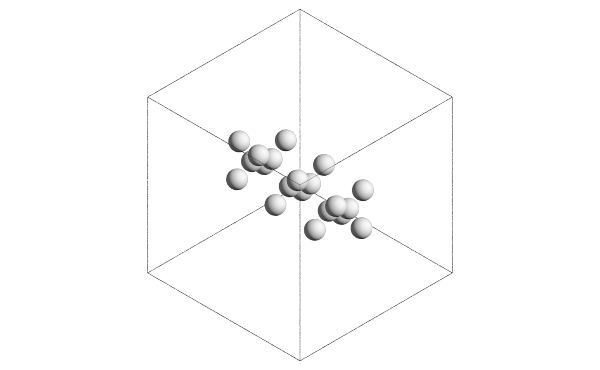

In [7]:
import fresnel

#set up the scene
scene = fresnel.Scene()

# Spheres for every particle in the system
geometry = fresnel.geometry.Sphere(scene, N=atomistic_frame.particles.N)
# assign each sphere positions from frame 
geometry.position[:] = atomistic_frame.particles.position

# create box in fresnel
box =fresnel.geometry.Box(scene, atomistic_frame.configuration.box,box_radius=0.01)
# make camera 
scene.camera = fresnel.camera.Orthographic.fit(scene)
# quick render
fresnel.preview(scene)

### Changes: colors, sizes, and viewpoint

The snapshot above does not show the different atom types, and can be improved. For this, we will follow the[ GSD visualization tutorial](https://fresnel.readthedocs.io/en/v0.13.7/examples/02-Advanced-topics/05-GSD-visualization.html) and color the particles based on their type and change their sizes. For more options for colors and materials see:

- [Material Properties](https://fresnel.readthedocs.io/en/stable/examples/00-Basic-tutorials/02-Material-properties.html)
- [Sphere Geometry](https://fresnel.readthedocs.io/en/stable/examples/01-Primitives/00-Sphere-geometry.html)

We will also use `Perspective` for the camera settings - which means we will have to figure out a good `position` and `height` for it, see the [camera documentation](https://fresnel.readthedocs.io/en/stable/module-camera.html).

If a snapshot is for visualization purposes only (as we are doing here), creative freedom can be used to generate visually clear images. Sometimes that might mean making particles artificially smaller, or rendering them (semi-)transparent, or leaving them out completely (e.g., solvent). If a snapshot is for a schematic explaining a model or molecule parametrisation, sticking to actual model parameters as much possible is a good idea. 

Adapt the code to make the carbon `C` atoms dark gray, and the `H` atoms white. Change the camera positions in such a way that you get a good view of the entire molecule. Adjust the sizes of the atoms to make the `C` atoms a little bigger than the `H` atoms. You do not need to obey actual size ratios, although it might be helpful for some models to do that. 

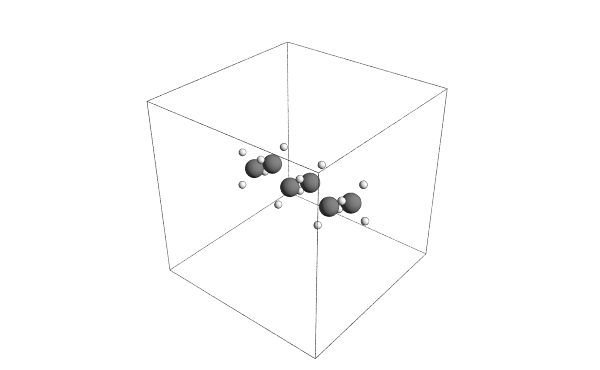

In [8]:

L = atomistic_frame.configuration.box[0]

scene.camera = fresnel.camera.Perspective(position=(L*1.8, L*1.8, L * 2.2), look_at=(0, 0, 0), up=(0, 1, 0), height=0.28)

particle_types = atomistic_frame.particles.typeid
colors = numpy.empty((atomistic_frame.particles.N, 3))
radius = numpy.empty(atomistic_frame.particles.N)

# Color by typeid
colors[particle_types == 0] = [0.5, 0.5, 0.5] # C
colors[particle_types == 1] = [1, 1, 1] # H

# Set material properties 
geometry.material = fresnel.material.Material(roughness=0.5)
geometry.outline_width = 0.02

# use color instead of material.color
geometry.material.primitive_color_mix = 1.0
geometry.color[:] = fresnel.color.linear(colors)

# Size by typeid 
radius[particle_types == 0] = 0.5 # C
radius[particle_types == 1] = 0.2 # H
geometry.radius[:] = radius

fresnel.preview(scene)

### Add bonds to simple snapshot

The above rendering is already much better than the default settings. However, bonds are missing!
For any (macro-)molecules, we will also want to visualize their topology. We use [`fresnel.geometry.Cylinder`](https://fresnel.readthedocs.io/en/stable/examples/01-Primitives/01-Cylinder-geometry.html) for this. You need to calculate the positions of the bonds using information from the data in `hoomd.Frame`. For this, modify the code to compute the end points of the cylinders that represent the bonds:

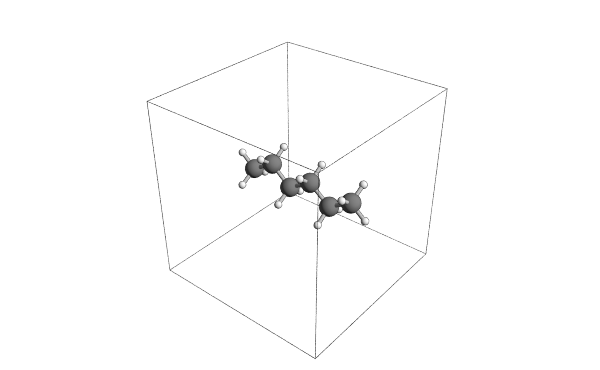

In [9]:
bonds = fresnel.geometry.Cylinder(scene, N=atomistic_frame.bonds.N)
bonds.material = fresnel.material.Material(roughness=0.5)
bonds.outline_width = 0.02

all_bonds = numpy.stack(
    [
        atomistic_frame.particles.position[atomistic_frame.bonds.group[:, 0]],
        atomistic_frame.particles.position[atomistic_frame.bonds.group[:, 1]],
    ],
    axis=1,
)

bonds.points[:] = all_bonds
bonds.radius[:] = [0.1]*atomistic_frame.bonds.N
bonds.material.primitive_color_mix = 1.0
bonds.color[:] = fresnel.color.linear([0.8, 0.8, 0.8])
fresnel.preview(scene)

### Render a high-resolution snapshot

This looks good! Feel free to play around with the settings, materials, colors, bond thickness, etc. We might want to also render a "high-resolution" image and save it somewhere: 

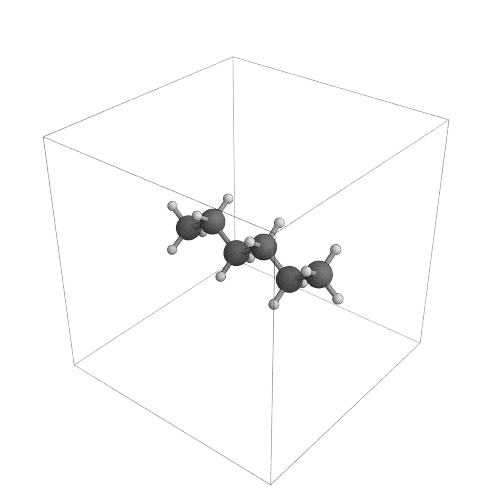

In [10]:
import PIL
scene.lights = fresnel.light.rembrandt()
scene.background_color =(1,1,1)
scene.background_alpha = 1
out = fresnel.pathtrace(scene, w=500, h=500, light_samples=20)
image = PIL.Image.fromarray(out[:], mode='RGB')
image.save('output.png')
out

## Coarse-graining the molecule

The above molecular configuration is for an atomistic representation. We can now attempt to do a simple *"coarse-graining"* of this molecule. For proper coarse grained models see, for example, these publications: 

- Peters, Brandon L., et al. "Coarse-grained modeling of polyethylene melts: Effect on dynamics." Journal of Chemical Theory and Computation 13.6 (2017): 2890-2896.
- Panizon, E., Bochicchio, D., Monticelli, L., & Rossi, G. (2015). MARTINI coarse-grained models of polyethylene and polypropylene. The Journal of Physical Chemistry B, 119(25), 8209-8216.
- Rahman, S., Lobanova, O., Correia-Braga, C., Raptis, V., & Müller, E. A. (2014). SAFT-γ force field for the simulation of molecular fluids. 5. Hetero-group coarse-grained models of linear alkanes and the importance of intra-molecular interactions. J. Phys. Chem. B.
- Dhamankar, Satyen, and Michael A. Webb. "Chemically specific coarse‐graining of polymers: methods and prospects." Journal of Polymer Science 59.22 (2021): 2613-2643.
- ...
  
Note that there are *many* different models for simple polymers like PE availaibe. When selecting which one to use, consider your specific scientific questions and hypotheses. 

What we will do, is simply the very first step of most coarse-graining procedure, and that is to decide on: 
- The *"level"* of coarse-graining, i.e, how many heavy atoms are grouped into one bead. For united atom models, that is 1. For the Martini force field that is 4, for generic polymer models this is often given by the *Kuhn* segment size (anywhere from 4-20).
- The *location* and size of the coarse-grained beads.

Here, we will use a coarse-graining level of 2 (i.e 2 carbons in one coarse-grained bead) and will simply put their centers in the center of mass of the two carbon atoms. **Note:** we have ignored the end-effects, i.e the fact that the first and last carbon have 3 `H` bonded to them. For long polymers, this is commonly considered a good assumtion. 

Calculate the positions of the CG representation, their bonds, and make a `gsd.hoomd.Frame` with the coarse-grained model: 

In [11]:
cg_frame = gsd.hoomd.Frame()

positions = numpy.asarray(atomistic_positions[0:6])
cg_positions = 0.5*(positions[0::2] + positions[1::2])
cg_bonds = numpy.array([[0,1],[1,2]])
cg_frame.particles.N = len(cg_positions)
cg_frame.particles.position = cg_positions

cg_frame.particles.types = ['A']
cg_frame.particles.typeid = numpy.ones(cg_frame.particles.N)

cg_frame.bonds.N = len(cg_bonds)
cg_frame.bonds.group = cg_bonds

cg_frame.configuration.box = [10, 10, 10, 0, 0, 0]


### Render snapshot of coarse-grained molecule
Now, let's render that configuration to check our work. We will assign them a different color and particle type to make sure not to confuse the two models/representations: 

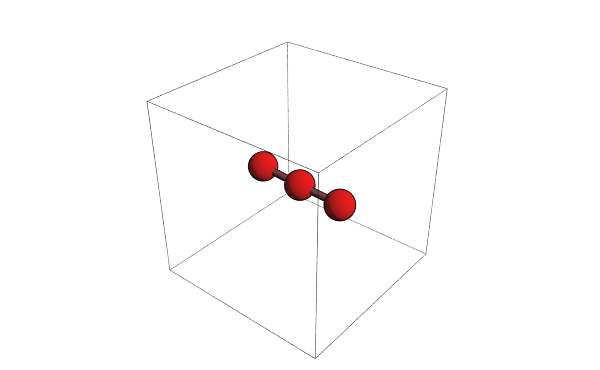

In [12]:
scene = fresnel.Scene()

# Spheres for every particle in the system
geometry = fresnel.geometry.Sphere(scene, N=cg_frame.particles.N)
geometry.position[:] = cg_frame.particles.position

# create box in fresnel
box = fresnel.geometry.Box(scene, cg_frame.configuration.box,box_radius=0.01)

L = cg_frame.configuration.box[0]
scene.camera = fresnel.camera.Perspective(position=(L*1.8, L*1.8, L * 2.2), look_at=(0, 0, 0), up=(0, 1, 0), height=0.28)

geometry.material = fresnel.material.Material(roughness=0.9,spec_trans=0.8)
geometry.outline_width = 0.05

# use color instead of material.color
geometry.material.primitive_color_mix = 1.0
geometry.color[:] = fresnel.color.linear([0.9,0,0])

geometry.radius[:] = 0.8

bonds = fresnel.geometry.Cylinder(scene, N=cg_frame.bonds.N)
bonds.material = fresnel.material.Material(roughness=0.5)
bonds.outline_width = 0.05

all_bonds = numpy.stack(
    [
        cg_frame.particles.position[cg_frame.bonds.group[:, 0]],
        cg_frame.particles.position[cg_frame.bonds.group[:, 1]],
    ],
    axis=1,
)
bonds.points[:] = all_bonds
bonds.radius[:] = [0.2]
bonds.material.primitive_color_mix = 1.0
bonds.color[:] = fresnel.color.linear([0.6, 0.3, 0.3])
fresnel.preview(scene)


## Videos of trajectories 

Let's pretend we have a (time) evolution of a system, i.e a trajectory and not just a snapshot. We will mimic this here by adding random displacements to the positions, imitating thermal fluctuations. Later in this workshop, we **will** do proper simulations! 

First, we define a function that generates a frame (or snapshot). Modify the code to add small random displacements to the initial positions: 

In [13]:
def make_frame(i):
    frame = gsd.hoomd.Frame()
    frame.configuration.step = i
    frame.particles.N = len(atomistic_positions)
    frame.particles.types = ['C', 'H']
    frame.particles.typeid = numpy.ones(len(atomistic_positions))
    frame.particles.typeid[0:6]=0
    frame.bonds.N = len(atomistic_bonds)
    frame.bonds.group = atomistic_bonds
    frame.configuration.box = [10, 10, 10, 0, 0, 0]
    
    frame.particles.position = atomistic_positions + numpy.random.normal(0,0.1,size=(len(atomistic_positions),3))
    return frame 


For convinience, we will define a function that will take a single frame, render it and return the result. Take the code from above, and wrap it into a function: 

In [14]:
import numpy
import packaging.version
import PIL
import io 
import IPython
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display 

def render_frame(frame):
    scene = fresnel.Scene()
    fresnel.geometry.Box(scene, cg_frame.configuration.box,box_radius=0.01)
    geometry = fresnel.geometry.Sphere(scene, N=frame.particles.N)
    geometry.position[:] = frame.particles.position 
    
    particle_types = frame.particles.typeid
    colors = numpy.empty((atomistic_frame.particles.N, 3))
    radius = numpy.empty(atomistic_frame.particles.N)
    
    # Color by typeid
    colors[particle_types == 0] = [0.5, 0.5, 0.5] # C
    colors[particle_types == 1] = [1, 1, 1] # H
    geometry.material = fresnel.material.Material(roughness=0.1)
    geometry.outline_width = 0.05
    geometry.material.primitive_color_mix = 1.0
    geometry.color[:] = fresnel.color.linear(colors)
    
    # Size by typeid 
    radius[particle_types == 0] = 0.5 # C
    radius[particle_types == 1] = 0.2 # H
    geometry.radius[:] = radius
    
    bonds = fresnel.geometry.Cylinder(scene, N=frame.bonds.N)
    bonds.material = fresnel.material.Material(roughness=0.5)
    bonds.outline_width = 0.05
    all_bonds = numpy.stack(
        [
            frame.particles.position[frame.bonds.group[:, 0]],
            frame.particles.position[frame.bonds.group[:, 1]],
        ],
        axis=1,
    )
    bonds.points[:] = all_bonds
    bonds.radius[:] = [0.1]*atomistic_frame.bonds.N
    
    L = frame.configuration.box[0]
    scene.background_color =(1,1,1)
    scene.background_alpha = 1
    scene.camera = fresnel.camera.Perspective(position=(L*1.8, L*1.8, L * 2.2), look_at=(0, 0, 0), up=(0, 1, 0), height=0.28)
        
    a = fresnel.preview(scene)
    im0 = PIL.Image.fromarray(a[:, :, 0:3], mode="RGB").convert("P", palette=PIL.Image.Palette.ADAPTIVE)
    return im0


Functions like the one above will be used throught this workshop to quickly render snapshots of the simulations we will do later. 

Then we can call this function `10` times to generate a trajectory. We will save the result in a `GSD` file for convinience, since saving it in arrays becomes inconvinient:

In [15]:
trajectory = gsd.hoomd.open(name='example.gsd', mode='w')
trajectory.extend((make_frame(i) for i in range(10)))
trajectory.flush()  # making sure the trajectory is written to disk.


Now we can open the GSD file and render each frame and stich the result together into one `.gif` file:

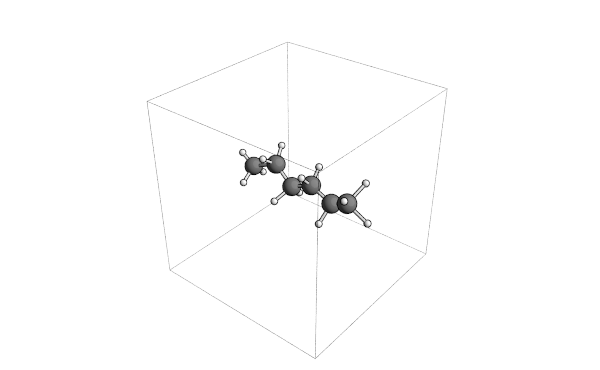

In [16]:
ims = []

im0 = render_frame(trajectory[0])
for frame in trajectory[1:]:
    a = render_frame(frame)
    ims.append(a)  

filename = 'test.gif'
im0.save(filename, "gif", save_all=True, append_images=ims, duration=20, loop=0)

with open(filename,'rb') as f:
    display.Image(data=f.read(), format='png')
    

## Additions 

1. Change colors, sizes, viewpoint 
2. Change bond thickness, bond colors
3. Change lighting, materials, etc. to improve the quality of your renderings
4. Save a single snapshot into a gsd file, open the gsd file and render the snapshot. Write well defined functions for this.  

## More additions

Render both representations (atomistic + coarse-grained) in one snapshot. **Hint:** Use transparency. For this, define two sets of `fresnel.geometry.Sphere` (one for atomistic, one for coarse-grained) and tune their properties independently. When using transparent spheres, also use `fresnel.light.lightbox` and `fresnel.pathtrace`, other lights and `fresnel.preview` can have odd artifacts with transparend spheres.

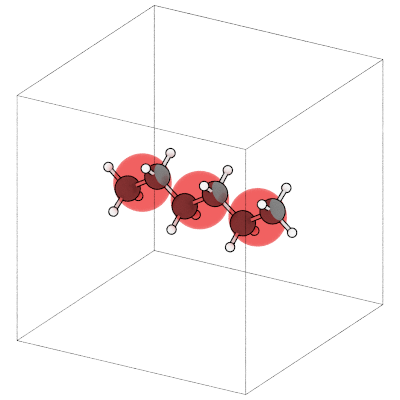

In [17]:
scene2 = fresnel.Scene()

# create box in fresnel
box = fresnel.geometry.Box(scene2, cg_frame.configuration.box,box_radius=0.01)

# Spheres for every particle in the system
geometry1 = fresnel.geometry.Sphere(scene2, N=cg_frame.particles.N)
geometry1.position[:] = cg_frame.particles.position 
geometry1.material = fresnel.material.Material(spec_trans=0.999,roughness=0.1,specular=0.99)

# use color instead of material.color
geometry1.material.primitive_color_mix = 1.0
geometry1.color[:] = fresnel.color.linear([0.99,0.4,0.4])
geometry1.radius[:] = 1.1


geometry2 = fresnel.geometry.Sphere(scene2, N=atomistic_frame.particles.N)
geometry2.position[:] = atomistic_frame.particles.position 

particle_types = atomistic_frame.particles.typeid
colors = numpy.empty((atomistic_frame.particles.N, 3))
radius = numpy.empty(atomistic_frame.particles.N)

# Color by typeid
colors[particle_types == 0] = [0.5, 0.5, 0.5] # C
colors[particle_types == 1] = [1, 1, 1] # H

geometry2.material = fresnel.material.Material(roughness=0.1)
geometry2.outline_width = 0.05

# use color instead of material.color
geometry2.material.primitive_color_mix = 1.0
geometry2.color[:] = fresnel.color.linear(colors)

# Size by typeid 
radius[particle_types == 0] = 0.5 # C
radius[particle_types == 1] = 0.2 # H

geometry2.radius[:] = radius

bonds = fresnel.geometry.Cylinder(scene2, N=atomistic_frame.bonds.N)
bonds.material = fresnel.material.Material(roughness=0.5)
bonds.outline_width = 0.05

all_bonds = numpy.stack(
    [
        atomistic_frame.particles.position[atomistic_frame.bonds.group[:, 0]],
        atomistic_frame.particles.position[atomistic_frame.bonds.group[:, 1]],
    ],
    axis=1,
)
bonds.points[:] = all_bonds
bonds.radius[:] = [0.1]*atomistic_frame.bonds.N
bonds.color[:] = fresnel.color.linear([0, .95, 0])

L = cg_frame.configuration.box[0]
scene2.camera = fresnel.camera.Orthographic(position=(L * 1.2, L, L * 2), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.4 + 1)

# create box in fresnel
scene2.background_color =(1,1,1)
scene2.background_alpha = 1.0

scene2.lights =  fresnel.light.lightbox()
fresnel.pathtrace(scene2, w=400, h=400, light_samples=50)